In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error

In [ ]:
# Load your dataset
data = pd.read_csv('Final_Dataset.csv')

##Pre Processing
data["MeanTemperature"] = (data["MaxTemp"] + data["MinTemp"])/2
data["TR"] = (data["MaxTemp"] - data["MinTemp"])

#Traditional Hargreaves Model
data['Hargreave'] = 0.0023*0.408*data['Rad']*(data['MeanTemperature']+17.8)*pow(data['TR'],0.5)

In [ ]:
data.isnull().sum()

RegionStation       0
Month               0
MinTemp             0
MaxTemp             0
Humidity            0
Wind                0
SunHours            0
Rad                 0
Eto_mm/day          0
SoilType           12
MeanTemperature     0
TR                  0
Hargreave           0
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
#Mean as an Intercept
data.loc[data['SoilType'] == "Black" , 'Const'] = 1.988
data.loc[data['SoilType'] == "Red" , 'Const'] = 1.72
data.loc[data['SoilType'] == "Alluvial" , 'Const'] = 1.707
data.loc[data['SoilType'] == "Sandy" , 'Const'] = 1.959
data.loc[data['SoilType'] == "Lateritic" , 'Const'] = 1.979
data.loc[data['SoilType'] == "Laterite" , 'Const'] = 1.979
data.loc[data['SoilType'] == "Black " , 'Const'] = 1.988
data.loc[data['SoilType'] == "Red " , 'Const'] = 1.72

data['Mod_Har'] = data['Hargreave']+ data['Const']
data.head()

,RegionStation,Month,MinTemp,MaxTemp,Humidity,Wind,SunHours,Rad,Eto_mm/day,SoilType,MeanTemperature,TR,Hargreave,Const,Mod_Har
0,Agra,January,8.0,22.3,56,52,7.1,13.5,1.91,Alluvial,15.15,14.3,1.578502,1.707,3.285502
1,Agra,February,10.4,25.2,45,69,8.2,16.8,2.70,Alluvial,17.80,14.8,2.159127,1.707,3.866127
2,Agra,March,15.9,32.0,24,69,8.1,19.3,3.73,Alluvial,23.95,16.1,3.033994,1.707,4.740994
3,Agra,April,22.3,38.5,17,95,8.8,22.2,5.41,Alluvial,30.40,16.2,4.041527,1.707,5.748527
4,Agra,May,26.4,41.6,22,95,8.3,22.4,6.05,Alluvial,34.00,15.2,4.245097,1.707,5.952097


In [ ]:
data = data.dropna()

In [ ]:
# Extract features and target variable
X = data[['Rad','TR','MeanTemperature','SoilType']]
y = data['Mod_Har']

# Encode categorical columns (RegionStation and Month) using LabelEncoder
label_encoder = LabelEncoder()
#X['RegionStation'] = label_encoder.fit_transform(X['RegionStation'])
#X['Month'] = label_encoder.fit_transform(X['Month'])

# Encode the 'SoilType' column using One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse=False)
soil_type_encoded = onehot_encoder.fit_transform(X['SoilType'].values.reshape(-1, 1))

# Combine the one-hot encoded 'SoilType' with the rest of the features
X_encoded = np.hstack((X.drop(columns=['SoilType']).values, soil_type_encoded))

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Standardize your input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#FNN

In [ ]:
# Define your FNN model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Lists to store MSE and Accuracy values during training
train_mse_values = []
val_mse_values = []

# Train the model and record MSE values at each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

    # Calculate MSE for training and validation sets
    train_mse = history.history['loss'][0]
    val_mse = history.history['val_loss'][0]

    # Append MSE values to lists
    train_mse_values.append(train_mse)
    val_mse_values.append(val_mse)

    # Print MSE values for each epoch
    print(f"Epoch {epoch+1}/{50} - Training MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}")

49/49 [==============================] - 1s 6ms/step - loss: 7.3172 - val_loss: 0.9111
Epoch 1/50 - Training MSE: 7.3172 - Validation MSE: 0.9111
49/49 [==============================] - 0s 4ms/step - loss: 0.4937 - val_loss: 0.2783
Epoch 2/50 - Training MSE: 0.4937 - Validation MSE: 0.2783
49/49 [==============================] - 0s 4ms/step - loss: 0.2043 - val_loss: 0.1461
Epoch 3/50 - Training MSE: 0.2043 - Validation MSE: 0.1461
49/49 [==============================] - 0s 4ms/step - loss: 0.1162 - val_loss: 0.0915
Epoch 4/50 - Training MSE: 0.1162 - Validation MSE: 0.0915
49/49 [==============================] - 0s 5ms/step - loss: 0.0737 - val_loss: 0.0615
Epoch 5/50 - Training MSE: 0.0737 - Validation MSE: 0.0615
49/49 [==============================] - 0s 4ms/step - loss: 0.0505 - val_loss: 0.0430
Epoch 6/50 - Training MSE: 0.0505 - Validation MSE: 0.0430
49/49 [==============================] - 0s 4ms/step - loss: 0.0370 - val_loss: 0.0327
Epoch 7/50 - Training MSE: 0.0370 - V

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 64)                576       
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the model
y_pred = model.predict(X_val)
final_mse = mean_squared_error(y_val, y_pred)
final_mae = mean_absolute_error(y_val, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, y_pred)

print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

13/13 [==============================] - 0s 2ms/step
Final Mean Squared Error on Validation Set: 0.0010
Final Mean Absolute Error on Validation Set: 0.0217
Final Root Mean Squared Error on Validation Set: 0.0311
Final R-squared (R2) Score on Validation Set: 0.9988


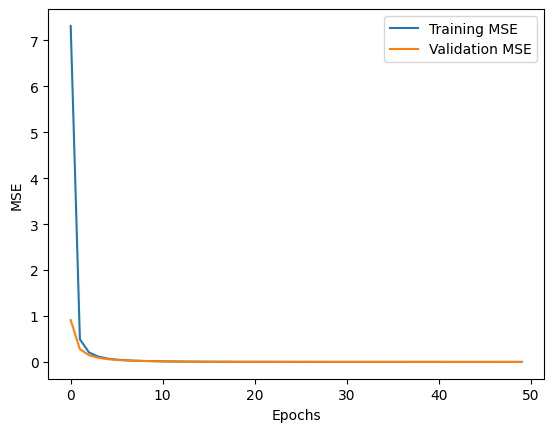

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_mse_values, label='Training MSE')
plt.plot(val_mse_values, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

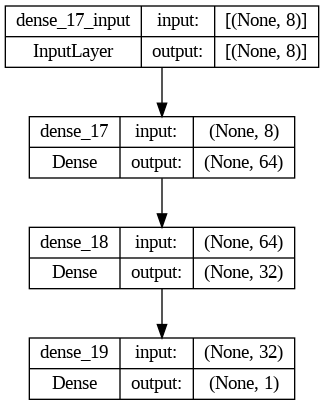

In [ ]:
from tensorflow.keras.utils import plot_model

# Generate a visualization of the model and save it to a file
plot_model(model, to_file='modelFNN.png', show_shapes=True, show_layer_names=True)

# Display the model
from IPython.display import Image
Image("modelFNN.png")

#RNN

In [ ]:
# Reshape the input data for LSTM
input_shape = (X_train.shape[1], 1)  # Adjust the input shape as needed
X_train = X_train.reshape(-1, input_shape[0], input_shape[1])
X_val = X_val.reshape(-1, input_shape[0], input_shape[1])

"""
# Define your LSTM-based model
model = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=input_shape),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])"""

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8, 128)            66560     
                                                                 
 lstm_4 (LSTM)               (None, 8, 64)             49408     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 151,105
Trainable params: 151,105
Non-tr

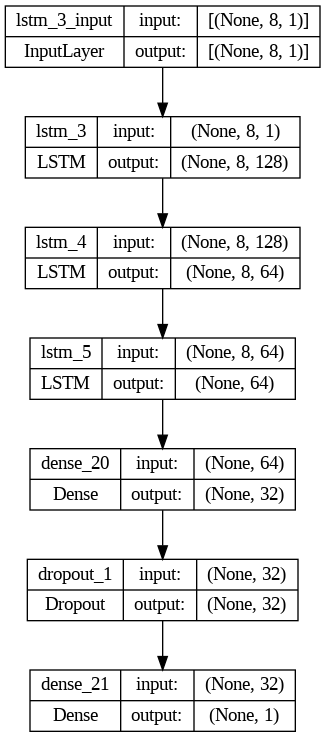

In [ ]:
# Generate a visualization of the model and save it to a file
plot_model(model, to_file='modelRNN.png', show_shapes=True, show_layer_names=True)

# Display the model
from IPython.display import Image
Image("modelRNN.png")

In [ ]:
# Train the model and record MSE values at each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

    # Calculate MSE for training and validation sets
    train_mse = history.history['loss'][0]
    val_mse = history.history['val_loss'][0]

    # Append MSE values to lists
    train_mse_values.append(train_mse)
    val_mse_values.append(val_mse)

    # Print MSE values for each epoch
    print(f"Epoch {epoch+1}/{50} - Training MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}")

49/49 [==============================] - 12s 60ms/step - loss: 6.6475 - val_loss: 0.3363
Epoch 1/50 - Training MSE: 6.6475 - Validation MSE: 0.3363
49/49 [==============================] - 2s 34ms/step - loss: 0.6871 - val_loss: 0.1127
Epoch 2/50 - Training MSE: 0.6871 - Validation MSE: 0.1127
49/49 [==============================] - 2s 34ms/step - loss: 0.5121 - val_loss: 0.0721
Epoch 3/50 - Training MSE: 0.5121 - Validation MSE: 0.0721
49/49 [==============================] - 2s 33ms/step - loss: 0.4485 - val_loss: 0.0689
Epoch 4/50 - Training MSE: 0.4485 - Validation MSE: 0.0689
49/49 [==============================] - 3s 55ms/step - loss: 0.3943 - val_loss: 0.0559
Epoch 5/50 - Training MSE: 0.3943 - Validation MSE: 0.0559
49/49 [==============================] - 2s 44ms/step - loss: 0.4048 - val_loss: 0.0572
Epoch 6/50 - Training MSE: 0.4048 - Validation MSE: 0.0572
49/49 [==============================] - 2s 35ms/step - loss: 0.3565 - val_loss: 0.0506
Epoch 7/50 - Training MSE: 0.

In [ ]:
# Evaluate the model
y_pred = model.predict(X_val)
final_mse = mean_squared_error(y_val, y_pred)
final_mae = mean_absolute_error(y_val, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, y_pred)

print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

13/13 [==============================] - 1s 10ms/step
Final Mean Squared Error on Validation Set: 0.0248
Final Mean Absolute Error on Validation Set: 0.1260
Final Root Mean Squared Error on Validation Set: 0.1574
Final R-squared (R2) Score on Validation Set: 0.9680


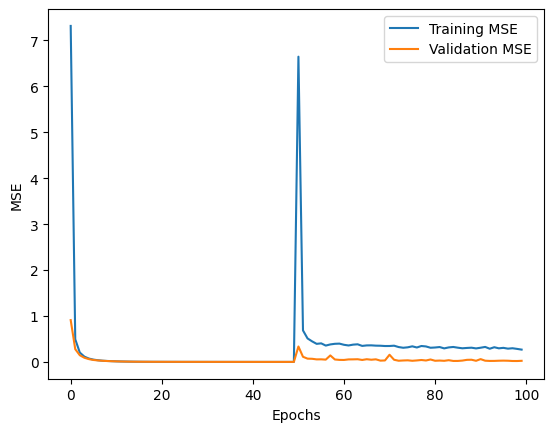

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_mse_values, label='Training MSE')
plt.plot(val_mse_values, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Ensemble

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
# Define your deep learning models
def create_dl_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create a list of deep learning models
dl_models = [create_dl_model(X_train.shape[1:]) for _ in range(3)]  # Create 3 deep learning models

# Train the deep learning models
for model in dl_models:
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)  # Adjust epochs and batch size as needed

# Make predictions using the deep learning models
dl_preds = [model.predict(X_val) for model in dl_models]

Epoch 1/50
49/49 [==============================] - 1s 3ms/step - loss: 16.7949
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 8.0289
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 2.2820
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 1.3865
Epoch 5/50
49/49 [==============================] - 0s 3ms/step - loss: 1.0349
Epoch 6/50
49/49 [==============================] - 0s 3ms/step - loss: 0.8694
Epoch 7/50
49/49 [==============================] - 0s 3ms/step - loss: 0.7916
Epoch 8/50
49/49 [==============================] - 0s 3ms/step - loss: 0.7596
Epoch 9/50
49/49 [==============================] - 0s 3ms/step - loss: 0.7429
Epoch 10/50
49/49 [==============================] - 0s 3ms/step - loss: 0.7331
Epoch 11/50
49/49 [==============================] - 0s 3ms/step - loss: 0.7274
Epoch 12/50
49/49 [==============================] - 0s 2ms/step - loss: 0.7242
Epoch 13/50
49/49 [=============================

In [ ]:
# Stack the deep learning predictions as features
stacked_X_val = np.column_stack(dl_preds)

# Flatten the stacked predictions
stacked_X_val_flat = np.reshape(stacked_X_val, (stacked_X_val.shape[0], -1))

# Train a meta-model (e.g., Linear Regression) on the flattened stacked predictions
meta_model = LinearRegression()
meta_model.fit(stacked_X_val_flat, y_val)

# Make predictions using the ensemble
stacked_dl_preds = [model.predict(X_val) for model in dl_models]
stacked_X_val = np.column_stack(stacked_dl_preds)

# Flatten the stacked predictions for validation
stacked_X_val_flat = np.reshape(stacked_X_val, (stacked_X_val.shape[0], -1))

# Predict using the meta-model
ensemble_preds = meta_model.predict(stacked_X_val_flat)

# Evaluate the ensemble model
ensemble_mse = mean_squared_error(y_val, ensemble_preds)
print(f"Ensemble Mean Squared Error on Validation Set: {ensemble_mse}")

13/13 [==============================] - 0s 3ms/step
Ensemble Mean Squared Error on Validation Set: 0.1020699540595728


In [ ]:
final_mse = mean_squared_error(y_val, ensemble_preds)
final_mae = mean_absolute_error(y_val, ensemble_preds)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, ensemble_preds)

print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

Final Mean Squared Error on Validation Set: 0.1021
Final Mean Absolute Error on Validation Set: 0.2527
Final Root Mean Squared Error on Validation Set: 0.3195
Final R-squared (R2) Score on Validation Set: 0.8682


#Different Ratios

###For 40% Test Set

In [ ]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.4, random_state=42)

# Standardize your input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

####FNN

25/25 [==============================] - 0s 1ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.0018
Final Mean Absolute Error on Validation Set: 0.0298
Final Root Mean Squared Error on Validation Set: 0.0424
Final R-squared (R2) Score on Validation Set: 0.9976
--------------------------------------------------------------------------


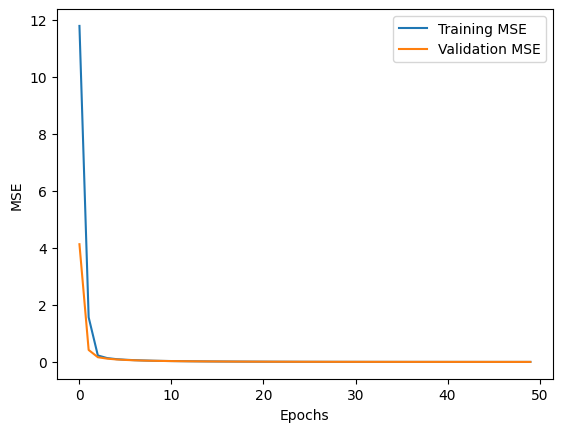

In [ ]:
# Define your FNN model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Lists to store MSE and Accuracy values during training
train_mse_values = []
val_mse_values = []

# Train the model and record MSE values at each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

    # Calculate MSE for training and validation sets
    train_mse = history.history['loss'][0]
    val_mse = history.history['val_loss'][0]

    # Append MSE values to lists
    train_mse_values.append(train_mse)
    val_mse_values.append(val_mse)

    # Print MSE values for each epoch
    #print(f"Epoch {epoch+1}/{50} - Training MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}")

# Evaluate the model
y_pred = model.predict(X_val)
final_mse = mean_squared_error(y_val, y_pred)
final_mae = mean_absolute_error(y_val, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, y_pred)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

print("--------------------------------------------------------------------------")
plt.plot(train_mse_values, label='Training MSE')
plt.plot(val_mse_values, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

####RNN

25/25 [==============================] - 2s 10ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.0283
Final Mean Absolute Error on Validation Set: 0.1381
Final Root Mean Squared Error on Validation Set: 0.1682
Final R-squared (R2) Score on Validation Set: 0.9629
--------------------------------------------------------------------------


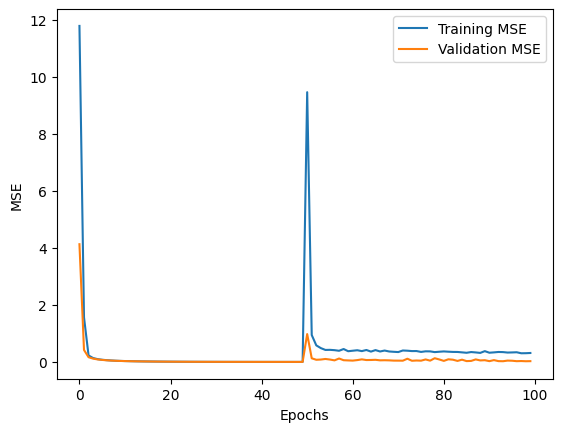

In [ ]:
# Reshape the input data for LSTM
input_shape = (X_train.shape[1], 1)  # Adjust the input shape as needed
X_train = X_train.reshape(-1, input_shape[0], input_shape[1])
X_val = X_val.reshape(-1, input_shape[0], input_shape[1])

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and record MSE values at each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

    # Calculate MSE for training and validation sets
    train_mse = history.history['loss'][0]
    val_mse = history.history['val_loss'][0]

    # Append MSE values to lists
    train_mse_values.append(train_mse)
    val_mse_values.append(val_mse)

    # Print MSE values for each epoch
    #print(f"Epoch {epoch+1}/{50} - Training MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}")

# Evaluate the model
y_pred = model.predict(X_val)
final_mse = mean_squared_error(y_val, y_pred)
final_mae = mean_absolute_error(y_val, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, y_pred)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

print("--------------------------------------------------------------------------")
plt.plot(train_mse_values, label='Training MSE')
plt.plot(val_mse_values, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

####Ensemble

In [ ]:
# Define your deep learning models
def create_dl_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create a list of deep learning models
dl_models = [create_dl_model(X_train.shape[1:]) for _ in range(3)]  # Create 3 deep learning models

# Train the deep learning models
for model in dl_models:
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)  # Adjust epochs and batch size as needed

# Make predictions using the deep learning models
dl_preds = [model.predict(X_val) for model in dl_models]

# Stack the deep learning predictions as features
stacked_X_val = np.column_stack(dl_preds)

# Flatten the stacked predictions
stacked_X_val_flat = np.reshape(stacked_X_val, (stacked_X_val.shape[0], -1))

# Train a meta-model (e.g., Linear Regression) on the flattened stacked predictions
meta_model = LinearRegression()
meta_model.fit(stacked_X_val_flat, y_val)

# Make predictions using the ensemble
stacked_dl_preds = [model.predict(X_val) for model in dl_models]
stacked_X_val = np.column_stack(stacked_dl_preds)

# Flatten the stacked predictions for validation
stacked_X_val_flat = np.reshape(stacked_X_val, (stacked_X_val.shape[0], -1))

# Predict using the meta-model
ensemble_preds = meta_model.predict(stacked_X_val_flat)

final_mse = mean_squared_error(y_val, ensemble_preds)
final_mae = mean_absolute_error(y_val, ensemble_preds)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, ensemble_preds)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

25/25 [==============================] - 0s 2ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.0268
Final Mean Absolute Error on Validation Set: 0.1255
Final Root Mean Squared Error on Validation Set: 0.1637
Final R-squared (R2) Score on Validation Set: 0.9648


###For 60% Test Set

In [ ]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.6, random_state=42)

# Standardize your input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

####FNN

37/37 [==============================] - 0s 1ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.0033
Final Mean Absolute Error on Validation Set: 0.0422
Final Root Mean Squared Error on Validation Set: 0.0577
Final R-squared (R2) Score on Validation Set: 0.9958
--------------------------------------------------------------------------


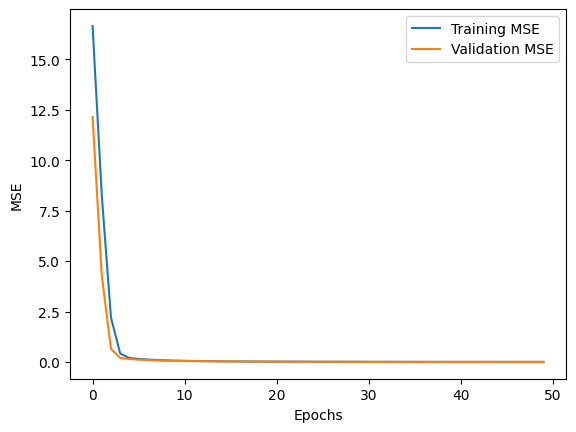

In [ ]:
# Define your FNN model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Lists to store MSE and Accuracy values during training
train_mse_values = []
val_mse_values = []

# Train the model and record MSE values at each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

    # Calculate MSE for training and validation sets
    train_mse = history.history['loss'][0]
    val_mse = history.history['val_loss'][0]

    # Append MSE values to lists
    train_mse_values.append(train_mse)
    val_mse_values.append(val_mse)

    # Print MSE values for each epoch
    #print(f"Epoch {epoch+1}/{50} - Training MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}")

# Evaluate the model
y_pred = model.predict(X_val)
final_mse = mean_squared_error(y_val, y_pred)
final_mae = mean_absolute_error(y_val, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, y_pred)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

print("--------------------------------------------------------------------------")
plt.plot(train_mse_values, label='Training MSE')
plt.plot(val_mse_values, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

####RNN

37/37 [==============================] - 3s 16ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.0371
Final Mean Absolute Error on Validation Set: 0.1581
Final Root Mean Squared Error on Validation Set: 0.1927
Final R-squared (R2) Score on Validation Set: 0.9534
--------------------------------------------------------------------------


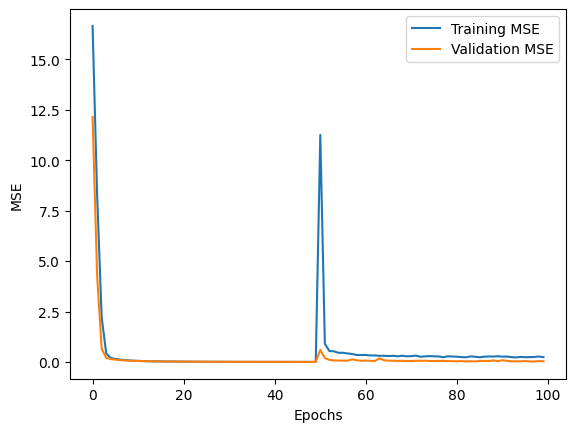

In [ ]:
# Reshape the input data for LSTM
input_shape = (X_train.shape[1], 1)  # Adjust the input shape as needed
X_train = X_train.reshape(-1, input_shape[0], input_shape[1])
X_val = X_val.reshape(-1, input_shape[0], input_shape[1])

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and record MSE values at each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

    # Calculate MSE for training and validation sets
    train_mse = history.history['loss'][0]
    val_mse = history.history['val_loss'][0]

    # Append MSE values to lists
    train_mse_values.append(train_mse)
    val_mse_values.append(val_mse)

    # Print MSE values for each epoch
    #print(f"Epoch {epoch+1}/{50} - Training MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}")

# Evaluate the model
y_pred = model.predict(X_val)
final_mse = mean_squared_error(y_val, y_pred)
final_mae = mean_absolute_error(y_val, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, y_pred)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

print("--------------------------------------------------------------------------")
plt.plot(train_mse_values, label='Training MSE')
plt.plot(val_mse_values, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

####Ensemble

In [ ]:
# Define your deep learning models
def create_dl_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create a list of deep learning models
dl_models = [create_dl_model(X_train.shape[1:]) for _ in range(3)]  # Create 3 deep learning models

# Train the deep learning models
for model in dl_models:
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)  # Adjust epochs and batch size as needed

# Make predictions using the deep learning models
dl_preds = [model.predict(X_val) for model in dl_models]

# Stack the deep learning predictions as features
stacked_X_val = np.column_stack(dl_preds)

# Flatten the stacked predictions
stacked_X_val_flat = np.reshape(stacked_X_val, (stacked_X_val.shape[0], -1))

# Train a meta-model (e.g., Linear Regression) on the flattened stacked predictions
meta_model = LinearRegression()
meta_model.fit(stacked_X_val_flat, y_val)

# Make predictions using the ensemble
stacked_dl_preds = [model.predict(X_val) for model in dl_models]
stacked_X_val = np.column_stack(stacked_dl_preds)

# Flatten the stacked predictions for validation
stacked_X_val_flat = np.reshape(stacked_X_val, (stacked_X_val.shape[0], -1))

# Predict using the meta-model
ensemble_preds = meta_model.predict(stacked_X_val_flat)

final_mse = mean_squared_error(y_val, ensemble_preds)
final_mae = mean_absolute_error(y_val, ensemble_preds)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, ensemble_preds)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

37/37 [==============================] - 0s 2ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.1043
Final Mean Absolute Error on Validation Set: 0.2476
Final Root Mean Squared Error on Validation Set: 0.3229
Final R-squared (R2) Score on Validation Set: 0.8692


###For 75% Test Set

In [ ]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.75, random_state=42)

# Standardize your input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

####FNN

46/46 [==============================] - 0s 2ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.0058
Final Mean Absolute Error on Validation Set: 0.0515
Final Root Mean Squared Error on Validation Set: 0.0763
Final R-squared (R2) Score on Validation Set: 0.9929
--------------------------------------------------------------------------


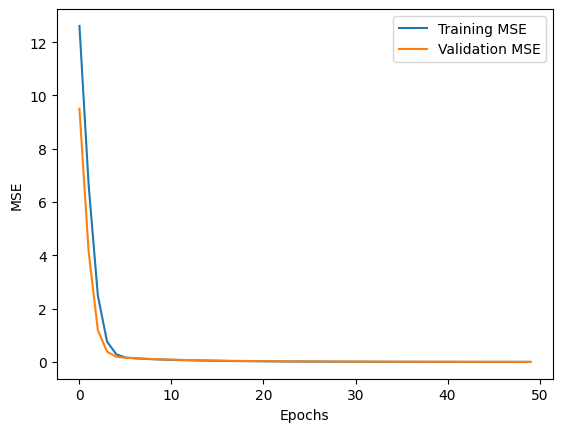

In [ ]:
# Define your FNN model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Lists to store MSE and Accuracy values during training
train_mse_values = []
val_mse_values = []

# Train the model and record MSE values at each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

    # Calculate MSE for training and validation sets
    train_mse = history.history['loss'][0]
    val_mse = history.history['val_loss'][0]

    # Append MSE values to lists
    train_mse_values.append(train_mse)
    val_mse_values.append(val_mse)

    # Print MSE values for each epoch
    #print(f"Epoch {epoch+1}/{50} - Training MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}")

# Evaluate the model
y_pred = model.predict(X_val)
final_mse = mean_squared_error(y_val, y_pred)
final_mae = mean_absolute_error(y_val, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, y_pred)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

print("--------------------------------------------------------------------------")
plt.plot(train_mse_values, label='Training MSE')
plt.plot(val_mse_values, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

####RNN

46/46 [==============================] - 3s 17ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.0622
Final Mean Absolute Error on Validation Set: 0.2042
Final Root Mean Squared Error on Validation Set: 0.2494
Final R-squared (R2) Score on Validation Set: 0.9242
--------------------------------------------------------------------------


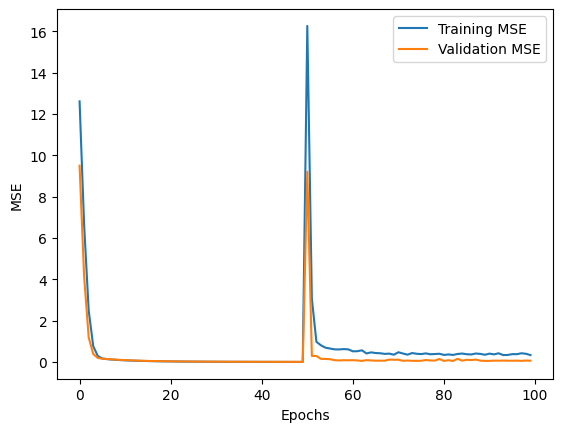

In [ ]:
# Reshape the input data for LSTM
input_shape = (X_train.shape[1], 1)  # Adjust the input shape as needed
X_train = X_train.reshape(-1, input_shape[0], input_shape[1])
X_val = X_val.reshape(-1, input_shape[0], input_shape[1])

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and record MSE values at each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

    # Calculate MSE for training and validation sets
    train_mse = history.history['loss'][0]
    val_mse = history.history['val_loss'][0]

    # Append MSE values to lists
    train_mse_values.append(train_mse)
    val_mse_values.append(val_mse)

    # Print MSE values for each epoch
    #print(f"Epoch {epoch+1}/{50} - Training MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}")

# Evaluate the model
y_pred = model.predict(X_val)
final_mse = mean_squared_error(y_val, y_pred)
final_mae = mean_absolute_error(y_val, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, y_pred)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

print("--------------------------------------------------------------------------")
plt.plot(train_mse_values, label='Training MSE')
plt.plot(val_mse_values, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

####Ensemble

In [ ]:
# Define your deep learning models
def create_dl_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create a list of deep learning models
dl_models = [create_dl_model(X_train.shape[1:]) for _ in range(3)]  # Create 3 deep learning models

# Train the deep learning models
for model in dl_models:
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)  # Adjust epochs and batch size as needed

# Make predictions using the deep learning models
dl_preds = [model.predict(X_val) for model in dl_models]

# Stack the deep learning predictions as features
stacked_X_val = np.column_stack(dl_preds)

# Flatten the stacked predictions
stacked_X_val_flat = np.reshape(stacked_X_val, (stacked_X_val.shape[0], -1))

# Train a meta-model (e.g., Linear Regression) on the flattened stacked predictions
meta_model = LinearRegression()
meta_model.fit(stacked_X_val_flat, y_val)

# Make predictions using the ensemble
stacked_dl_preds = [model.predict(X_val) for model in dl_models]
stacked_X_val = np.column_stack(stacked_dl_preds)

# Flatten the stacked predictions for validation
stacked_X_val_flat = np.reshape(stacked_X_val, (stacked_X_val.shape[0], -1))

# Predict using the meta-model
ensemble_preds = meta_model.predict(stacked_X_val_flat)

final_mse = mean_squared_error(y_val, ensemble_preds)
final_mae = mean_absolute_error(y_val, ensemble_preds)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, ensemble_preds)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

46/46 [==============================] - 0s 3ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.1246
Final Mean Absolute Error on Validation Set: 0.2706
Final Root Mean Squared Error on Validation Set: 0.3531
Final R-squared (R2) Score on Validation Set: 0.8481


###For 80% Test Set

In [ ]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.8, random_state=42)

# Standardize your input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

####FNN

49/49 [==============================] - 0s 2ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.0141
Final Mean Absolute Error on Validation Set: 0.0869
Final Root Mean Squared Error on Validation Set: 0.1188
Final R-squared (R2) Score on Validation Set: 0.9825
--------------------------------------------------------------------------


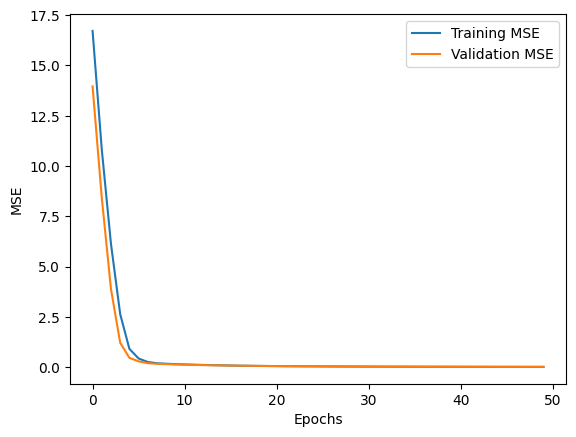

In [ ]:
# Define your FNN model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Lists to store MSE and Accuracy values during training
train_mse_values = []
val_mse_values = []

# Train the model and record MSE values at each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

    # Calculate MSE for training and validation sets
    train_mse = history.history['loss'][0]
    val_mse = history.history['val_loss'][0]

    # Append MSE values to lists
    train_mse_values.append(train_mse)
    val_mse_values.append(val_mse)

    # Print MSE values for each epoch
    #print(f"Epoch {epoch+1}/{50} - Training MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}")

# Evaluate the model
y_pred = model.predict(X_val)
final_mse = mean_squared_error(y_val, y_pred)
final_mae = mean_absolute_error(y_val, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, y_pred)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

print("--------------------------------------------------------------------------")
plt.plot(train_mse_values, label='Training MSE')
plt.plot(val_mse_values, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

####RNN

49/49 [==============================] - 3s 15ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.0789
Final Mean Absolute Error on Validation Set: 0.2306
Final Root Mean Squared Error on Validation Set: 0.2810
Final R-squared (R2) Score on Validation Set: 0.9021
--------------------------------------------------------------------------


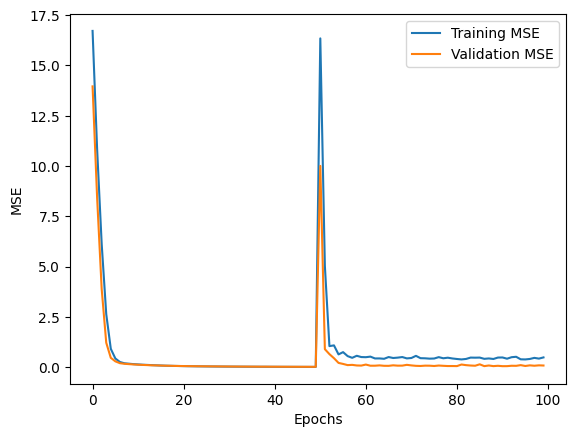

In [ ]:
# Reshape the input data for LSTM
input_shape = (X_train.shape[1], 1)  # Adjust the input shape as needed
X_train = X_train.reshape(-1, input_shape[0], input_shape[1])
X_val = X_val.reshape(-1, input_shape[0], input_shape[1])

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and record MSE values at each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

    # Calculate MSE for training and validation sets
    train_mse = history.history['loss'][0]
    val_mse = history.history['val_loss'][0]

    # Append MSE values to lists
    train_mse_values.append(train_mse)
    val_mse_values.append(val_mse)

    # Print MSE values for each epoch
    #print(f"Epoch {epoch+1}/{50} - Training MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f}")

# Evaluate the model
y_pred = model.predict(X_val)
final_mse = mean_squared_error(y_val, y_pred)
final_mae = mean_absolute_error(y_val, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, y_pred)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

print("--------------------------------------------------------------------------")
plt.plot(train_mse_values, label='Training MSE')
plt.plot(val_mse_values, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

####Ensemble

In [ ]:
# Define your deep learning models
def create_dl_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create a list of deep learning models
dl_models = [create_dl_model(X_train.shape[1:]) for _ in range(3)]  # Create 3 deep learning models

# Train the deep learning models
for model in dl_models:
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)  # Adjust epochs and batch size as needed

# Make predictions using the deep learning models
dl_preds = [model.predict(X_val) for model in dl_models]

# Stack the deep learning predictions as features
stacked_X_val = np.column_stack(dl_preds)

# Flatten the stacked predictions
stacked_X_val_flat = np.reshape(stacked_X_val, (stacked_X_val.shape[0], -1))

# Train a meta-model (e.g., Linear Regression) on the flattened stacked predictions
meta_model = LinearRegression()
meta_model.fit(stacked_X_val_flat, y_val)

# Make predictions using the ensemble
stacked_dl_preds = [model.predict(X_val) for model in dl_models]
stacked_X_val = np.column_stack(stacked_dl_preds)

# Flatten the stacked predictions for validation
stacked_X_val_flat = np.reshape(stacked_X_val, (stacked_X_val.shape[0], -1))

# Predict using the meta-model
ensemble_preds = meta_model.predict(stacked_X_val_flat)

final_mse = mean_squared_error(y_val, ensemble_preds)
final_mae = mean_absolute_error(y_val, ensemble_preds)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_val, ensemble_preds)

print("--------------------------------------------------------------------------")
print(f"Final Mean Squared Error on Validation Set: {final_mse:.4f}")
print(f"Final Mean Absolute Error on Validation Set: {final_mae:.4f}")
print(f"Final Root Mean Squared Error on Validation Set: {final_rmse:.4f}")
print(f"Final R-squared (R2) Score on Validation Set: {final_r2:.4f}")

49/49 [==============================] - 0s 2ms/step
--------------------------------------------------------------------------
Final Mean Squared Error on Validation Set: 0.0958
Final Mean Absolute Error on Validation Set: 0.2335
Final Root Mean Squared Error on Validation Set: 0.3095
Final R-squared (R2) Score on Validation Set: 0.8811
